# MNIST Digit classification 

Objective is to prepare a convolutional neural network that can achieve about 99.4% validation accuracy with model parameters less than 20K.

## Necessary packages

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

!pip install torchsummary
from torchsummary import summary
from torchvision import transforms, datasets, utils

## Prepare dataset

In [4]:
train_transform = transforms.Compose([
                                      transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])
test_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [5]:
train_dataset = datasets.MNIST(root='../data', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=test_transform, download=True)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
sample = next(iter(train_dataset))
data, label = sample
print(data.shape, type(data))

torch.Size([1, 28, 28]) <class 'torch.Tensor'>


Dataloaders

In [6]:
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, **kwargs)

In [ ]:
sample_images, sample_labels = next(iter(train_loader))
print(sample_images[:16].shape)

torch.Size([16, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 117, 117])


(-0.5, 116.5, 116.5, -0.5)

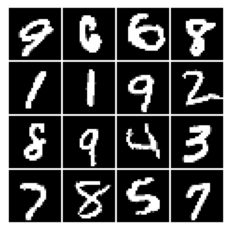

In [ ]:
grid_image = utils.make_grid(sample_images[:16], nrow=4, padding=1, pad_value=1)
print(grid_image.shape)
plt.imshow(grid_image.permute(1,2,0))
plt.axis('off')

## CNN model

In [37]:
# 4 block model
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)                        
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)                       
        )
        self.transitionblock1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=True),
            nn.ReLU()                     
        )

        # Maxpooling
        self.pool1 = nn.MaxPool2d(2, 2) 


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)                        
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)                        
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)                        
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)                        
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )

        self.translinear = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1, bias=True),
            )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transitionblock1(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.translinear(x)
        x = x.view(-1, 10)
        return x

In [38]:
use_cuda = torch.cuda.is_available()
# hid_dim =
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,456
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             170
             ReLU-10           [-1, 10, 24, 24]               0
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,456
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2

In [ ]:
for batch_id, batch in enumerate(train_loader):
    print(type(batch))
    break

<class 'list'>


## Train and Test

In [39]:
# Train
# batch = {"data": data, "target": target, "rand_num": rand_num, "sum_of_digits": sum_of_digits}
def train(model, device, train_loader, optimizer, criterion):
    model.train()

    # collect stats - for accuracy calculation
    correct = 0
    processed = 0
    batch_loss = 0
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_id, batch in enumerate(train_loader):
        data = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()

        # Gather prediction and calculate loss + backward pass + optimize weights
        label_pred = model(data)
        label_loss = criterion(label_pred, target)
        # Calculate gradients
        label_loss.backward()
        # Optimizer
        optimizer.step()

        # Metrics calculation- For epoch Accuracy(total correct pred/total items) and loss 
        pred = label_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        epoch_loss += label_loss.item()
    
    epoch_accuracy = (100*correct/processed)
    epoch_loss /= len(train_loader)
    print(f"Train set: Epoch Accuracy: {round(epoch_accuracy, 2)}  Epoch Loss: {round(epoch_loss, 4)}")

    return epoch_accuracy, epoch_loss

In [40]:
# Test
def test(model, device, test_loader, criterion):
    model.eval()

    # collect stats - for accuracy calculation
    correct = 0
    processed = 0
    batch_loss = 0
    epoch_loss = 0
    epoch_accuracy = 0

    with torch.no_grad():        
        for batch_id, batch in enumerate(test_loader):
            data = batch[0].to(device)
            target = batch[1].to(device)

            label_pred = model(data)
            label_loss = criterion(label_pred, target)

            # Metrics calculation
            pred = label_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            epoch_loss += label_loss.item()
        
    epoch_accuracy = (100*correct)/processed
    epoch_loss /= len(test_loader)
    print(f"Test set: Epoch Accuracy: {round(epoch_accuracy, 2)}  Epoch Loss: {round(epoch_loss, 4)}")
    return epoch_accuracy, epoch_loss

## Model training and Validation

In [41]:
EPOCHS = 20
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []

# Optimization algorithm from torch.optim
optimizer = optim.Adam(model.parameters(), lr=0.003)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2)
# Loss condition
criterion = nn.CrossEntropyLoss()

for epochs in range(EPOCHS):
    print(f"Epoch: {epochs}")
    train_acc_delta, train_loss_delta = train(model, device, train_loader, optimizer, criterion)
    test_acc_delta, test_loss_delta = test(model, device, test_loader, criterion)
    scheduler.step(test_loss_delta/len(test_loader))
    train_accuracy.append(round(train_acc_delta, 2))
    train_loss.append(round(train_loss_delta, 4))
    test_accuracy.append(round(test_acc_delta, 2))
    test_loss.append(round(test_loss_delta, 4))

Epoch: 0
Train set: Epoch Accuracy: 93.52  Epoch Loss: 0.2822
Test set: Epoch Accuracy: 98.32  Epoch Loss: 0.0544
Epoch: 1
Train set: Epoch Accuracy: 98.09  Epoch Loss: 0.0655
Test set: Epoch Accuracy: 98.64  Epoch Loss: 0.0409
Epoch: 2
Train set: Epoch Accuracy: 98.36  Epoch Loss: 0.0526
Test set: Epoch Accuracy: 98.98  Epoch Loss: 0.0328
Epoch: 3
Train set: Epoch Accuracy: 98.64  Epoch Loss: 0.0436
Test set: Epoch Accuracy: 99.04  Epoch Loss: 0.0275
Epoch: 4
Train set: Epoch Accuracy: 98.77  Epoch Loss: 0.04
Test set: Epoch Accuracy: 98.99  Epoch Loss: 0.0297
Epoch: 5
Train set: Epoch Accuracy: 98.8  Epoch Loss: 0.0374
Test set: Epoch Accuracy: 99.08  Epoch Loss: 0.0295
Epoch: 6
Train set: Epoch Accuracy: 98.88  Epoch Loss: 0.0373
Test set: Epoch Accuracy: 99.34  Epoch Loss: 0.0222
Epoch: 7
Train set: Epoch Accuracy: 98.94  Epoch Loss: 0.0351
Test set: Epoch Accuracy: 99.27  Epoch Loss: 0.0206
Epoch: 8
Train set: Epoch Accuracy: 98.98  Epoch Loss: 0.0333
Test set: Epoch Accuracy: 99.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

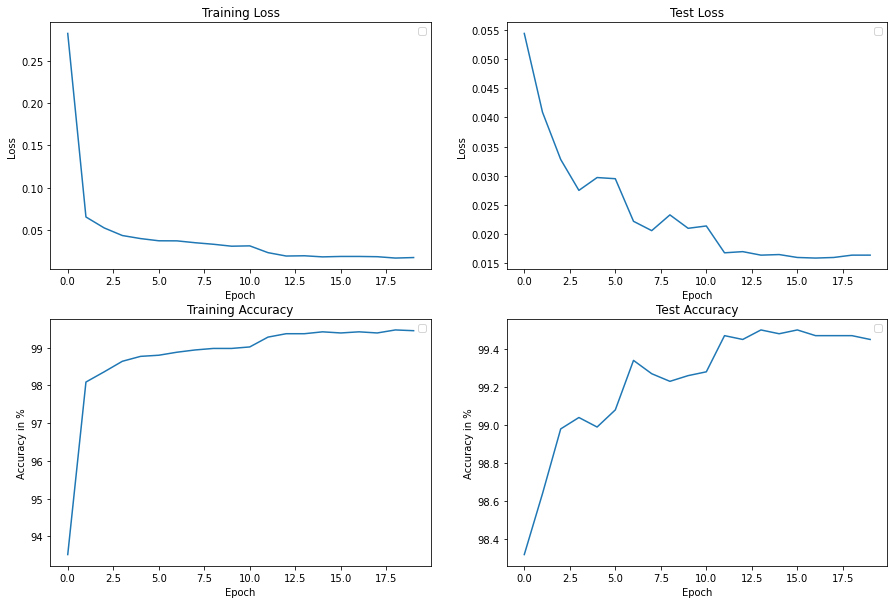

<Figure size 432x288 with 0 Axes>

In [42]:
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend(loc="best")

axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy in %")
axs[1, 0].legend(loc="best")

axs[0, 1].plot(test_loss)
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].set_title("Test Loss")
axs[0, 1].legend(loc="best")

axs[1, 1].plot(test_accuracy)
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy in %")
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].legend(loc="best")
plt.figure()